# 查看gpt2的模型架构

In [1]:
from transformers import GPT2LMHeadModel

/opt/anaconda3/envs/zyw_BuildNanogpt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_hf  = GPT2LMHeadModel.from_pretrained("/home/zhangyuanwang/Project/build-nanogpt/model/gpt2")# 124M，gpt2-xl是1500M参数
sd_hf = model_hf.state_dict()
for k,v in sd_hf.items():
    print(k,v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

# 测试自己编写的gpt2架构是否正确

使用自己编写的gpt2架构，使用huggingface上训练好的gpt2模型权重，进行文本续写

In [3]:
import torch
from torch.nn import functional as F
from train_gpt2 import GPT

num_return_sequences = 5
max_length = 30
device = torch.device("cuda:2")

# 加载模型权重
model = GPT.from_pretrained(model_type='gpt2', model_path='/home/zhangyuanwang/Project/build-nanogpt/model/gpt2')
model.eval()
model.to(device)

# 加载分词器
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("Hello, my dog is cute") # 转换后是一个长为6的token (15496, 11, 616, 3290, 318, 13779)
tokens = torch.tensor(tokens, dtype=torch.long) # (6,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5,6)
x = tokens.to(device) # 得到idx (B,T)=(5,6)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    logits = model(x)[0] # (B, T, vocab_size)
    # 获得最后一步的logits
    logits = logits[:, -1, :] # (B, vocab_size)
    # 获得概率值
    probs = F.softmax(logits, dim=-1)
    # 采样前50个概率最大的值，设置topk=50
    # 词汇概率topk_probs (5, 50)，词汇索引topk_indices (5, 50)
    topk_probs, topk_indices = torch.topk(probs, k=50, dim=-1)
    # 得到在50个词汇中的索引
    ix = torch.multinomial(topk_probs, num_samples=1) # (B, 1)
    # 得到词汇索引idx
    xcol = torch.gather(topk_indices, dim=-1, index=ix) # (B, 1)
    # 将预测结果添加到x中
    x = torch.cat((x, xcol), dim=1)

# 输出最终结果
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">",decoded)

loading weights from pretrained gpt: gpt2
> Hello, my dog is cute. I just want her to grow up loving me. Like I can really take care of her when we need her most
> Hello, my dog is cute and loving. I am so excited to be home because all my dog is going to have a good one to chew on
> Hello, my dog is cute and I didn't hear what he was saying to me. And it just so happened that I was supposed to go pick
> Hello, my dog is cute but doesn't know how to be in front of me. I was going for something simple to learn as I did an
> Hello, my dog is cute."

This is where we stand when it comes to "funneling a child into a coma" but,


# 查看datasets

In [5]:
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:100]
data

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [7]:
import tiktoken

enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens)

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13, 198, 198, 5962, 22307, 25, 198, 1639]


将长token堆叠起来

创建数据x和标签y

In [9]:
import torch 
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4,6)
y = buf[1:].view(4,6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


# 残差块造成的影响

多次残差累加可能会造成标准差较大

In [2]:
import torch
x = torch.zeros(768)
n = 100 # 假设有100层
for i in range(n):
    x += torch.randn(768)
print(x.std())

tensor(9.5679)


如果除以一个系数，就能够抵消残差块相加对标准差造成的影响

In [3]:
x = torch.zeros(768)
n = 100
for i in range(n):
    x += n**-0.5 * torch.randn(768)
print(x.std())

tensor(0.9772)


# 变化学习率

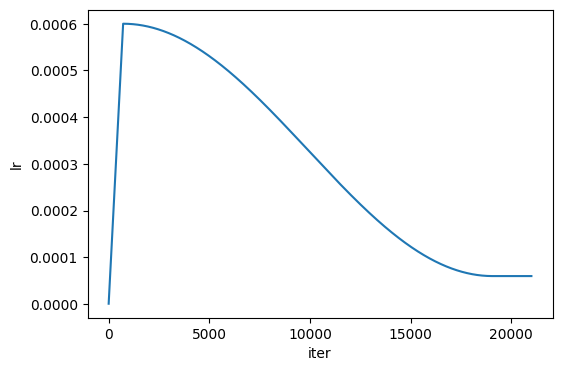

In [4]:
import math
import matplotlib.pyplot as plt

max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 715
max_steps = 19073 # 19,073 steps is ~1 epoch, if data is 10B tokens and batch size 0.5M tokens
def get_lr(it):
    # 1) 预热期，当iter数小于warmup_steps时，lr线性增加
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps 
    # 2) 稳定期，当iter数大于max_steps时，返回最小lr
    if it > max_steps:
        return min_lr
    # 3) 中间态，使用余弦退火算法
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)
lr_list = []
for iter in range(21000):
    lr = get_lr(iter)
    lr_list.append(lr)

plt.figure(figsize=(6, 4))
plt.plot(lr_list)
plt.xlabel('iter')
plt.ylabel('lr')
plt.savefig('./images/学习率变化图.png')
plt.show()

# 梯度累积

In [5]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

tensor([ 0.0331,  0.0307,  0.0061, -0.0363,  0.0187, -0.0415,  0.0159,  0.0077,
         0.0364, -0.0054])


In [12]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # <-- have to add back the "normalizer"!
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])


tensor([ 0.0331,  0.0307,  0.0061, -0.0363,  0.0187, -0.0415,  0.0159,  0.0077,
         0.0364, -0.0054])


In [14]:
loss.item()

0.10529038310050964

In [15]:
loss.detach()

tensor(0.1053)